In [1]:
# Tutorial source: https://nbviewer.jupyter.org/github/krasserm/face-recognition/blob/master/face-recognition.ipynb?flush_cache=true

In [1]:
import helper, os

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    helper.download_landmarks(dst_file)

Using TensorFlow backend.


In [2]:
metadata = helper.load_metadata('images')

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline


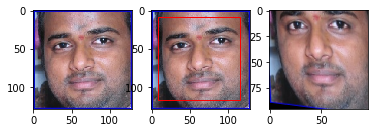

In [4]:
# Load an image of Jacques Chirac
jc_orig = helper.load_image(metadata[49].image_path())

# Detect face and return bounding box
bb = helper.get_largest_bounding_box(jc_orig)

# jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
jc_aligned = helper.align_image(jc_orig)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [5]:
metadata_orig = metadata
metadata = metadata[:10]

In [6]:
embedded = helper.create_embeddings(metadata_orig)

face_958744.jpg
face_908553.jpg
face_968215.jpg
face_9281.jpg
face_10206.jpg
face_942086.jpg
face_976792.jpg
face_2390.jpg
face_880697.jpg
face_929207.jpg
face_3861.jpg
face_872597.jpg
face_992562.jpg
face_8510.jpg
face_1759.jpg
face_639.jpg
face_6542.jpg
face_11628.jpg
face_9822.jpg
face_986844.jpg
face_9642.jpg
face_552.jpg
face_3461.jpg
face_1910.jpg
face_999508.jpg
face_3075.jpg
face_11684.jpg
face_992032.jpg
face_8283.jpg
face_9856.jpg
face_12295.jpg
face_911790.jpg
face_2069.jpg
face_871418.jpg
face_808031.jpg
face_999513.jpg
face_981543.jpg
face_10144.jpg
face_8508.jpg
face_990758.jpg
face_2918.jpg
face_10174.jpg
face_12026.jpg
face_1812.jpg
face_9298.jpg
face_999271.jpg
face_997942.jpg
face_8296.jpg
face_914408.jpg
face_986824.jpg
face_861070.jpg
face_844056.jpg
face_3463.jpg
face_241.jpg
face_3211.jpg
face_2223.jpg
face_282.jpg
face_480.jpg
face_983.jpg
face_2958.jpg
face_614.jpg
face_2934.jpg
face_1597.jpg
face_674.jpg
face_1052.jpg
face_3410.jpg
face_3511.jpg
face_1154.jpg
f

In [7]:
type(embedded)

numpy.ndarray

In [8]:
filename= "embedded.npy"
np.save(filename, embedded)
del embedded

NameError: name 'np' is not defined

In [28]:
embedded = np.load(filename)

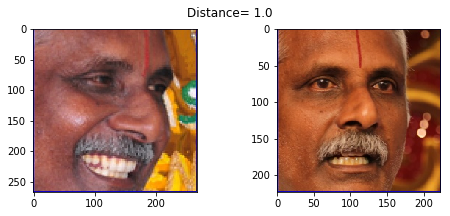

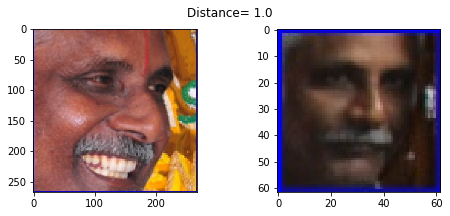

In [29]:
helper.show_pair(embedded, 2, 3)
helper.show_pair(embedded, 2, 5)

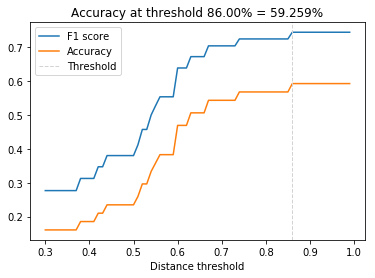

In [15]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {:.2%} = {:.3%}'.format(opt_tau, opt_acc));
plt.xlabel('Distance threshold')
plt.legend();

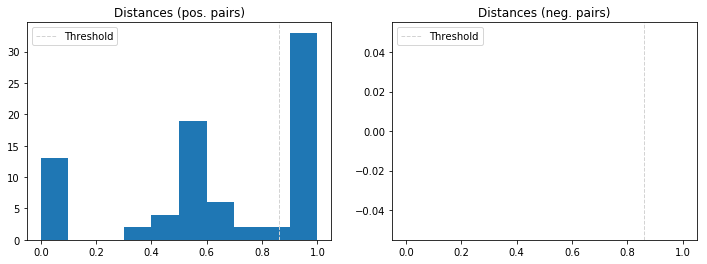

In [16]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn, acc_svc ))

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

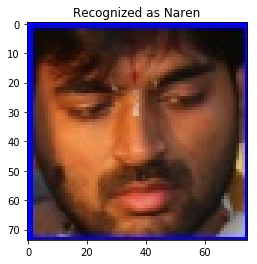

In [20]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 29

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title('Recognized as {}'.format(example_identity));

In [21]:
print(test_idx, example_idx)
metadata[test_idx][example_idx].image_path()

[ True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False] 29


'images/Naren/face_11778.jpg'

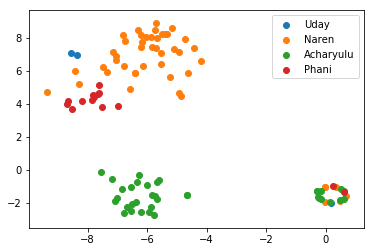

In [22]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));